## Dataset Loading and Preprocessing

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load and preprocess dataset
max_features = 10000  # Only top 10,000 words
max_len = 100  # Maximum length of reviews

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Pad sequences to make all reviews the same length
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
x_train shape: (25000, 100), x_test shape: (25000, 100)


## Loading GloVe Embeddings


In [2]:
import numpy as np

# Path to GloVe embeddings (update path if different)
glove_path = "data/glove/glove.6B.100d.txt"
embedding_dim = 100

# Load GloVe embeddings
embeddings_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")


Loaded 400000 word vectors.


## Loading GloVe Embeddings
This cell loads pre-trained GloVe embeddings into a dictionary.

- **Path to GloVe File:** `data/glove/glove.6B.100d.txt` (100-dimensional embeddings).
- **Output:** Prints the total number of word vectors loaded.
- **Purpose:** These embeddings will later initialize the embedding layer for the LSTM model.


In [3]:
import numpy as np

# Path to the GloVe file (update path if different)
glove_path = "data/glove/glove.6B.100d.txt"  # Using 100-dimensional embeddings
embedding_dim = 100  # Dimension of the GloVe vectors

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]  # The word
        coefs = np.asarray(values[1:], dtype="float32")  # The embedding vector
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")


Loaded 400000 word vectors.


## Preparing the Embedding Matrix
This cell constructs the embedding matrix for initializing the embedding layer in the LSTM model.

- **Word Index:** Maps words to integer indices using the IMDb dataset's vocabulary.
- **Embedding Matrix:** A `max_features x embedding_dim` matrix where:
  - Each row corresponds to a word's GloVe embedding.
  - Words not found in GloVe are assigned zero vectors.
- **Output:** Prints the shape of the embedding matrix.


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Load the IMDb word index to map indices back to words
word_index = imdb.get_word_index()

# Prepare the embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))  # Matrix size: [max_features x embedding_dim]
for word, i in word_index.items():
    if i < max_features:  # Only consider words in the vocabulary
        embedding_vector = embeddings_index.get(word)  # Get the GloVe embedding for the word
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Assign embedding to the matrix

print(f"Embedding matrix shape: {embedding_matrix.shape}")


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Embedding matrix shape: (10000, 100)


## LSTM Model


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the model
model = Sequential([
    Embedding(input_dim=max_features, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary after seeing input
x_dummy = np.zeros((1, max_len))  # Dummy input data (batch size 1, max_len)
model.build(input_shape=x_dummy.shape)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (1, 100, 100)          │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (1, 128)               │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,377 (4.26 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

## Training Code

In [17]:
# Training the model
batch_size = 32  # Number of samples per batch
epochs = 5  # Number of complete passes through the dataset

history = model.fit(
    x_train, y_train,  # Training data
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,  # Use 20% of the training data for validation
    verbose=1  # Display training progress
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.5376 - loss: 0.6937 - val_accuracy: 0.5910 - val_loss: 0.6704
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.5974 - loss: 0.6589 - val_accuracy: 0.6674 - val_loss: 0.6089
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.6728 - loss: 0.5992 - val_accuracy: 0.6882 - val_loss: 0.5752
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7149 - loss: 0.5481 - val_accuracy: 0.7118 - val_loss: 0.5418
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.7525 - loss: 0.5034 - val_accuracy: 0.7368 - val_loss: 0.5036


In [18]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.7438 - loss: 0.5023
Test Loss: 0.5009, Test Accuracy: 0.7470


## Plotting into Graph form

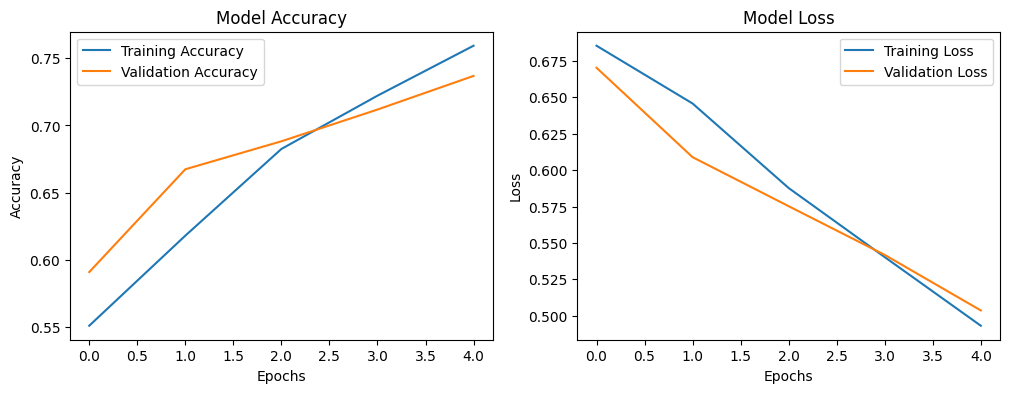

In [19]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Baseline Model

In [20]:
import numpy as np

# Calculate the majority class (most frequent label in the training set)
majority_class = np.round(np.mean(y_train))  # 1 if positive is the majority, else 0

# Predict the majority class for all test samples
y_baseline = np.full_like(y_test, majority_class)  # Array filled with the majority class

# Calculate accuracy for the baseline model
baseline_accuracy = np.mean(y_test == y_baseline)
print(f"Baseline Accuracy (Majority Class): {baseline_accuracy:.4f}")


Baseline Accuracy (Majority Class): 0.5000


## Fine-Tuning GloVe Embeddings
### Why Fine-Tune?
Fine-tuning the GloVe embeddings allows the model to adapt the pre-trained embeddings to the IMDb sentiment analysis dataset. This may improve accuracy as the embeddings become tailored to the specific task.

Below, we enable fine-tuning by setting `trainable=True` in the Embedding layer.


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the model with fine-tuning enabled
model = Sequential([
    Embedding(input_dim=max_features, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              trainable=True),  # Enable fine-tuning
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Build the model with an input shape
x_dummy = np.zeros((1, max_len))  # Dummy input data (batch size 1, max_len)
model.build(input_shape=x_dummy.shape)

# Display the updated summary
model.summary()



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (1, 100, 100)          │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (1, 128)               │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,377 (4.26 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Compile the model before training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the fine-tuned model
history_finetune = model.fit(
    x_train, y_train,  # Training data
    batch_size=32,  # Number of samples per batch
    epochs=5,  # Number of epochs
    validation_split=0.2,  # Use 20% of training data for validation
    verbose=1  # Display training progress
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.5605 - loss: 0.6765 - val_accuracy: 0.7860 - val_loss: 0.4593
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.8390 - loss: 0.3747 - val_accuracy: 0.8462 - val_loss: 0.3581
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.9094 - loss: 0.2335 - val_accuracy: 0.8376 - val_loss: 0.3979
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.9391 - loss: 0.1666 - val_accuracy: 0.8400 - val_loss: 0.4235
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9679 - loss: 0.1033 - val_accuracy: 0.8376 - val_loss: 0.4723


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=2,                   # Stop after 2 epochs of no improvement
    restore_best_weights=True     # Revert to the best model weights
)

# Train the model with early stopping
history_finetune_es = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,                    # Set a higher epoch count, early stopping will terminate early
    validation_split=0.2,
    callbacks=[early_stopping],   # Add the early stopping callback
    verbose=1
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.9797 - loss: 0.0724 - val_accuracy: 0.8348 - val_loss: 0.6625
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.9875 - loss: 0.0441 - val_accuracy: 0.8284 - val_loss: 0.7236
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.9921 - loss: 0.0299 - val_accuracy: 0.8248 - val_loss: 0.7223


In [27]:
# Evaluate the model
test_loss_es, test_accuracy_es = model.evaluate(x_test, y_test, batch_size=32)
print(f"Test Loss (Early Stopping): {test_loss_es:.4f}, Test Accuracy (Early Stopping): {test_accuracy_es:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.8227 - loss: 0.7067
Test Loss (Early Stopping): 0.7019, Test Accuracy (Early Stopping): 0.8234


In [28]:
from tensorflow.keras.layers import Bidirectional

# Define model with Bidirectional LSTM
model = Sequential([
    Embedding(input_dim=max_features, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              trainable=True),  # Fine-tune embeddings
    Bidirectional(LSTM(128)),  # Bidirectional LSTM
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_bilstm = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
test_loss_bilstm, test_accuracy_bilstm = model.evaluate(x_test, y_test, batch_size=32)
print(f"Test Loss (BiLSTM): {test_loss_bilstm:.4f}, Test Accuracy (BiLSTM): {test_accuracy_bilstm:.4f}")


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 96ms/step - accuracy: 0.5484 - loss: 0.6828 - val_accuracy: 0.7186 - val_loss: 0.5629
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.8120 - loss: 0.4146 - val_accuracy: 0.8144 - val_loss: 0.3981
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.9031 - loss: 0.2547 - val_accuracy: 0.8438 - val_loss: 0.3598
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 97ms/step - accuracy: 0.9429 - loss: 0.1589 - val_accuracy: 0.8496 - val_loss: 0.4284
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 100ms/step - accuracy: 0.9594 - loss: 0.1209 - val_accuracy: 0.8294 - val_loss: 0.5747
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.8191 - loss: 0.5914
Test Loss (BiLSTM): 0.5851, Test Accuracy (BiLSTM): 0.8218


## Bidirectional LSTM Implementation
### Why Bidirectional LSTMs?
Bidirectional LSTMs process text in both forward and backward directions, enabling the model to capture richer context for sentiment analysis. This can improve classification accuracy.


In [29]:
from tensorflow.keras.layers import Bidirectional

# Define model with Bidirectional LSTM
model_bilstm = Sequential([
    Embedding(input_dim=max_features, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              trainable=True),  # Fine-tune embeddings
    Bidirectional(LSTM(128)),  # Bidirectional LSTM
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_bilstm = model_bilstm.fit(
    x_train, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
test_loss_bilstm, test_accuracy_bilstm = model_bilstm.evaluate(x_test, y_test, batch_size=32)
print(f"Test Loss (BiLSTM): {test_loss_bilstm:.4f}, Test Accuracy (BiLSTM): {test_accuracy_bilstm:.4f}")


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 106ms/step - accuracy: 0.5782 - loss: 0.6620 - val_accuracy: 0.8148 - val_loss: 0.4078
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 98ms/step - accuracy: 0.8543 - loss: 0.3497 - val_accuracy: 0.8352 - val_loss: 0.3602
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.9138 - loss: 0.2292 - val_accuracy: 0.8446 - val_loss: 0.3584
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 100ms/step - accuracy: 0.9428 - loss: 0.1573 - val_accuracy: 0.8422 - val_loss: 0.3905
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.9711 - loss: 0.0940 - val_accuracy: 0.8376 - val_loss: 0.4664
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8293 - loss: 0.4993
Test Loss (BiLSTM): 0.4939, Test Accuracy (BiLSTM): 0.8317


## Additional Evaluation Metrics
### Why Precision, Recall, and F1-Score?
Accuracy alone may not fully reflect model performance, especially in cases of class imbalance. Metrics like precision, recall, and F1-score provide deeper insights into the model's predictions.


In [32]:
from sklearn.metrics import classification_report

# Predict on test data
y_pred_bilstm = (model_bilstm.predict(x_test) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred_bilstm, target_names=["Negative", "Positive"]))


782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step
              precision    recall  f1-score   support

    Negative       0.85      0.81      0.83     12500
    Positive       0.82      0.86      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



## Hyperparameter Tuning
### Why Optimize Hyperparameters?
Tuning parameters like learning rate, LSTM units, and batch size can significantly affect model performance, improving generalization and accuracy.


In [33]:
from tensorflow.keras.optimizers import Adam

# Define model with a lower learning rate
model_lr = Sequential([
    Embedding(input_dim=max_features, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              trainable=True),
    LSTM(128),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile with a reduced learning rate
model_lr.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_lr = model_lr.fit(
    x_train, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
test_loss_lr, test_accuracy_lr = model_lr.evaluate(x_test, y_test, batch_size=32)
print(f"Test Loss (Tuned LR): {test_loss_lr:.4f}, Test Accuracy (Tuned LR): {test_accuracy_lr:.4f}")


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 67ms/step - accuracy: 0.5134 - loss: 0.6994 - val_accuracy: 0.6272 - val_loss: 0.6573
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.6429 - loss: 0.6336 - val_accuracy: 0.7278 - val_loss: 0.5479
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.7479 - loss: 0.5159 - val_accuracy: 0.7716 - val_loss: 0.4779
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.8022 - loss: 0.4341 - val_accuracy: 0.7910 - val_loss: 0.4406
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8344 - loss: 0.3787 - val_accuracy: 0.8080 - val_loss: 0.4189
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.8102 - loss: 0.4108
Test Loss (Tuned LR): 0.4126, Test Accuracy (Tuned LR): 0.8105
